In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params
from pathlib import Path
import matplotlib as mpl
from scipy import constants

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

# set font size
mpl.rcParams.update({'font.size': 7})

formatter = FuncFormatter(thousands)

In [63]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [64]:
def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    

    # set minimum f -1000
    #melt_params['f'].min = -1000
    # top slope = bot slope
    #melt_params['a'].expr = 'c'
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)
    # try:
    #     melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    # except ValueError as e:
    #     if "The model function generated NaN values" in str(e):
    #         print("Caught the NaN generation error. Handling it...")
    #         return None
    #         # Handle the error, for example, by logging it, adjusting model parameters, or using default values
            
    #     else:
    #         print('some other error')
    #         # If the error message is different, you might want to raise the error again or handle it differently
    #         return None
    
    # remove outlier outside 1.5sigma
    # outlier = np.abs(melt_result.residual) > 150 * np.std(melt_result.residual)
    # if sum(outlier) > 0:
    #     x_no_outlier = x[~outlier]
    #     y_no_outlier = y[~outlier]
    #     melt_result = melt_model.fit(y_no_outlier, melt_params, x = x_no_outlier, method = 'least_squares')

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

In [65]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id
        FROM probe_tc_fit_runs r
        WHERE r.fit_kind = 'round2_global'
    )
    SELECT
        r.rg_id,
        MIN(pr.temperature) AS temperature,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'qc:r2'
                 THEN p.param_numeric END) AS r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id
    """
    )

# # Preprocess k_vals to get k_add-like values
# fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
# conc_DMS = 0.015852692  # in M, 1.5% v/v
# # log_kobs in nerd is kappa for now, need to correct later
# # new log_kobs below is K/K+1 kadd [P]_0
# fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg'] - np.log(conc_DMS) # adjust for 1.564 mM DMS
fit_params_df = fit_params_df[fit_params_df['temperature'] < 85]
fit_params_df['method'] = 'prime'

In [66]:
# Load all fit parameters for round3_constrained modrate fits
nmr_deg_fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id   AS fit_run_id,
            r.species,
            nr.temperature,
            nr.replicate
        FROM nmr_fit_runs r
        JOIN nmr_fit_params p_model
        ON p_model.fit_run_id = r.id
        AND p_model.param_name = 'model'
        AND p_model.param_text = 'lmfit_deg'
        JOIN nmr_reactions nr
        ON nr.id = r.nmr_reaction_id
    )
    SELECT
        r.species,
        r.temperature,
        r.replicate,

        MAX(CASE WHEN TRIM(p.param_name) IN ('k_value','k','k_obs')
                THEN p.param_numeric END) AS k_value,

        MAX(CASE WHEN TRIM(p.param_name) IN ('k_error','k_err','k_sigma')
                THEN p.param_numeric END) AS k_error,

        MAX(CASE WHEN TRIM(p.param_name) IN ('r2','qc:r2','diag:r2')
                THEN p.param_numeric END) AS r2

    FROM run r
    JOIN nmr_fit_params p
    ON p.fit_run_id = r.fit_run_id

    GROUP BY
        r.fit_run_id,
        r.species,
        r.temperature,
        r.replicate;
    """
    )

nmr_deg_fit_params_df['log_kdeg'] = np.log(nmr_deg_fit_params_df['k_value'])
nmr_deg_fit_params_df['log_kdeg_err'] = nmr_deg_fit_params_df['k_error'] / nmr_deg_fit_params_df['k_value']
nmr_deg_fit_params_df['inv_temp'] = 1/(273.15 + nmr_deg_fit_params_df['temperature'])
nmr_deg_fit_params_df['method'] = 'nmr'

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


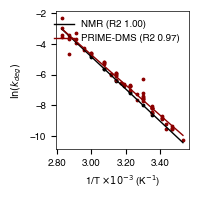

In [72]:
def linear_fit(df_kdeg):
    model = LinearModel()
    params = model.make_params()
    deg_result = model.fit(df_kdeg['log_kdeg'], params, x=df_kdeg['inv_temp'])
    return deg_result

# globally fitted kdeg vals - assessment of global fits
kdeg_curve = fit_params_df[fit_params_df['disp_name'].isin(['4U_a8c', '4U_wt'])]
kdeg_curve = kdeg_curve[['log_kdeg', 'temperature', 'disp_name']].drop_duplicates()
kdeg_curve['inv_temp'] = 1/(273.15 + kdeg_curve['temperature'])
kdeg_curve['log_kdeg'] = kdeg_curve['log_kdeg']

fourU_result = linear_fit(kdeg_curve)
nmr_result = linear_fit(nmr_deg_fit_params_df)

# calc best fit
x_range = np.array([min(kdeg_curve['inv_temp'].min(), nmr_deg_fit_params_df['inv_temp'].min()), 
                    max(kdeg_curve['inv_temp'].max(), nmr_deg_fit_params_df['inv_temp'].max())])
fourU_bestfit = fourU_result.eval(x = x_range)
nmr_bestfit = nmr_result.eval(x = x_range)

# get r2 values
r2_fourU = fourU_result.rsquared
r2_nmr = nmr_result.rsquared

fig, ax = plt.subplots(figsize = (2, 2))
ax.scatter(x = nmr_deg_fit_params_df['inv_temp'], y = nmr_deg_fit_params_df['log_kdeg'], s=3, color = 'black')
ax.plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = f'NMR (R2 {r2_nmr:.2f})')
ax.scatter(x = kdeg_curve['inv_temp'], y = kdeg_curve['log_kdeg'], s=3, color = 'darkred')
ax.plot(x_range, fourU_bestfit, color = 'darkred', linewidth = 1, label = f'PRIME-DMS (R2 {r2_fourU:.2f})')
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{deg})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.legend(frameon = False)
plt.tight_layout()
plt.savefig('lnkdeg_arrhenius.pdf')
plt.show()

In [1]:
import scipy.constants as sc

In [69]:
def extract_arrhenius_params(out, label):
    """Extract Arrhenius parameters from lmfit output."""

    R_kcal_per_mol_K = constants.R / constants.calorie / 1000  # kcal/(mol·K)

    slope = out.params[f'slope'].value
    slope_err = out.params[f'slope'].stderr
    intercept = out.params[f'intercept'].value
    intercept_err = out.params[f'intercept'].stderr

    ea = -slope * R_kcal_per_mol_K
    ea_err = slope_err * R_kcal_per_mol_K if slope_err is not None else None

    lnA = intercept
    lnA_err = intercept_err

    return {
        'group': label,
        'ea': ea,
        'ea_err': ea_err,
        'lnA': lnA,
        'lnA_err': lnA_err
    }

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


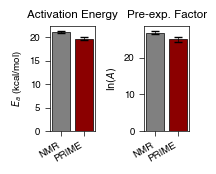

In [84]:
### Bar plot of Arrhenius parameters

# Prepare data
kdeg_arrhenius = pd.DataFrame([
    extract_arrhenius_params(fourU_result, 'prime'),
    extract_arrhenius_params(nmr_result, 'nmr')
    ])

# Map groups to display names and colors
group_labels = {
    'prime': 'PRIME',
    'nmr': 'NMR'
}
colors = {
    'prime': '#8B0000',   # dark red
    'nmr': 'gray',
}

# Set 'group' as the index for easier access
kdeg_arrhenius = kdeg_arrhenius.set_index('group')

# Define group order for plotting
groups = ['nmr', 'prime']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(2, 1.75), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    kdeg_arrhenius.loc[groups, 'ea'],
    yerr=kdeg_arrhenius.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
axs[0].set_title(r'Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    kdeg_arrhenius.loc[groups, 'lnA'],
    yerr=kdeg_arrhenius.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
axs[1].set_title(r'Pre-exp. Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('kdeg_arrhenius_barplot.pdf')
plt.show()